# Reason for this Script

As the intended functionality might give too many problems with memory, I decided to minimize the project a little bit. The goal is to have the model trained to only the word "Fernando" the name of my coffee machine and noise. This is more of minimal proof of concept script, showing that it is possible to have a KWS-Model run through a microcontroller

#### Import dependencies

In [1]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader

import torchaudio.transforms as T
import torchaudio.functional as F

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA GeForce RTX 3060


device(type='cuda')

## Dataset Class

In [2]:
class MyAudioDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000, transform=None):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.transform = transform

        # Collect all file paths and labels
        self.file_paths = []
        self.labels = []
        self.label_names = sorted(os.listdir(root_dir))

        for label_idx, label_name in enumerate(self.label_names):
            label_folder = os.path.join(root_dir, label_name)
            for file_name in os.listdir(label_folder):
                if file_name.endswith(".wav"):
                    self.file_paths.append(os.path.join(label_folder, file_name))
                    self.labels.append(label_idx)


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        waveform, sr = torchaudio.load(file_path)

        # Resample if needed
        if sr != self.sample_rate:
            waveform =  F.resample(
            waveform,
            sr,
            16000,
            lowpass_filter_width=64,
            rolloff=0.9475937167399596,
            resampling_method="sinc_interp_kaiser",
            beta=14.769656459379492,
        )

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Normalize loudness
        waveform = waveform / torch.max(torch.abs(waveform))

        # Pad shorter clips, trim longer clips
        max_len = self.sample_rate  # 1 second = 16000 samples
        if waveform.shape[1] < max_len:
            waveform = torch.nn.functional.pad(waveform, (0, max_len - waveform.shape[1]))
        else:
            waveform = waveform[:, :max_len]

        # Apply transforms (e.g. MelSpectrogram)
        if self.transform:
            features = self.transform(waveform)
        else:
            features = waveform
            
        return features, label



In [3]:
transform = T.MelSpectrogram(
    sample_rate=16000,
    n_mels=64,
    n_fft=1024,
    hop_length=512
)

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import random
from collections import defaultdict

# Step 1: Load full dataset
full_dataset = MyAudioDataset("data_min", sample_rate=16000, transform=transform)

# Step 2: Group indices by class
class_indices = defaultdict(list)
for idx in range(len(full_dataset)):
    _, label = full_dataset[idx]
    class_indices[label].append(idx)

# Step 3: Find minimum class count (so all classes are equal)
min_count = min(len(indices) for indices in class_indices.values())

# Step 4: Randomly sample equal number of items per class
balanced_indices = []
for indices in class_indices.values():
    balanced_indices.extend(random.sample(indices, min_count))

# Step 5: Shuffle all balanced indices
random.shuffle(balanced_indices)

# Step 6: Create a balanced Subset dataset
balanced_dataset = Subset(full_dataset, balanced_indices)

# Step 7: Split train/test from balanced dataset
train_size = int(0.8 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size

train_dataset, test_dataset = random_split(balanced_dataset, [train_size, test_size])

# Step 8: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Inspecting one batch

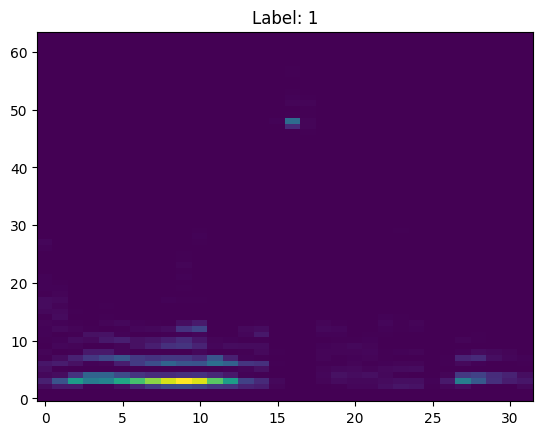

In [4]:
import matplotlib.pyplot as plt
mel, label = next(iter(train_loader))
plt.imshow(mel[0][0].cpu().numpy(), aspect='auto', origin='lower')
plt.title(f"Label: {label[0]}")
plt.show()

Minimal CNN Architecture

In [5]:
import torch.nn as nn

class KeywordCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # Global average pooling
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [batch, 1, n_mels, time]
        x = self.pool(torch.nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.nn.functional.relu(self.bn3(self.conv3(x))))
        
        # Global average pooling
        x = x.mean(dim=[2, 3])  # [batch, channels]
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [6]:
model = KeywordCNN(num_classes=len(full_dataset.label_names))

Minimal Training Loop

In [7]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.3521
Epoch 2, Loss: 0.1706
Epoch 3, Loss: 0.1302
Epoch 4, Loss: 0.1177
Epoch 5, Loss: 0.0999
Epoch 6, Loss: 0.0927
Epoch 7, Loss: 0.0690
Epoch 8, Loss: 0.0701
Epoch 9, Loss: 0.0610
Epoch 10, Loss: 0.0768


Save Model

In [8]:
model.eval()
torch.save(model.state_dict(), 'checkpoints/small_kws.pt')

Confusion Matrix

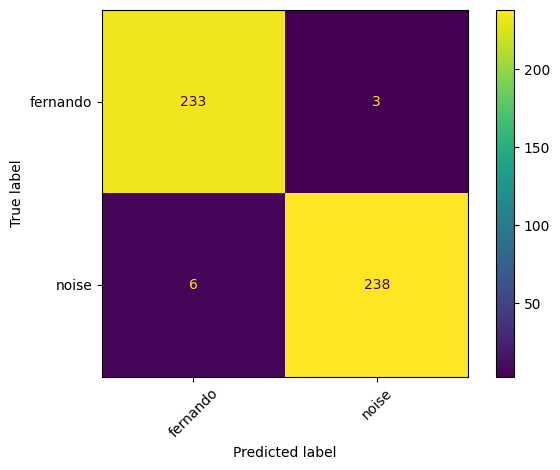

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch


model_int8 = KeywordCNN(num_classes=len(full_dataset.label_names))
state_dict = torch.load("checkpoints/small_kws.pt")
model_int8.load_state_dict(state_dict)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to("cpu").float()
        labels = labels.to("cpu")

        outputs = model_int8(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=full_dataset.label_names)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()